In [ ]:
import tensorflow as tf  
 
# Display the version
print(tf.__version__)    
 
# other imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Reshape, Add
from tensorflow.keras.layers import Layer, Softmax, ReLU
from tensorflow.keras.models import Model

# import KDL
#from KDLayers import *

2.9.2


In [ ]:
class KDRightLayer(Layer):
  def __init__(self,n,activation=None,init_factor=0.05):
    super(KDRightLayer, self).__init__()
    self.n = n
    self.activation = tf.keras.activations.get(activation)
    self.init_factor = init_factor

  def build(self, input_shape):
    self.q = input_shape[1]
    self.m = input_shape[2]
    # initialize the weights
    w_init = tf.random_normal_initializer(stddev=self.init_factor)
    self.w = tf.Variable(name="kernel", initial_value=w_init(shape=(self.m, self.n),
                         dtype='float32'),trainable=True)
    # initialize the biases
    b_init = tf.zeros_initializer()
    self.b = tf.Variable(name="bias",initial_value=b_init(shape=(self.q,self.n), dtype='float32'),
                         trainable=True)

  def call(self, inputs):
    return self.activation(tf.matmul(inputs, self.w) + self.b)

In [ ]:
class KDLeftLayer(Layer):
  def __init__(self,m,activation=None,init_factor=0.05):
    super(KDLeftLayer, self).__init__()
    self.m = m
    self.activation = tf.keras.activations.get(activation)
    self.init_factor = init_factor

  def build(self, input_shape):
    self.n = input_shape[1]
    self.p = input_shape[2]
    # initialize the weights
    w_init = tf.random_normal_initializer(stddev=self.init_factor)
    self.w = tf.Variable(name="kernel", initial_value=w_init(shape=(self.m, self.n),
                                                             dtype='float32'),trainable=True)
    # initialize the biases
    b_init = tf.zeros_initializer()
    self.b = tf.Variable(name="bias",initial_value=b_init(shape=(self.m,self.p), 
                                                          dtype='float32'),trainable=True)

  def call(self, inputs):
    # return self.activation(tf.matmul(self.w,inputs) + self.b) # doesn't work with SGD unless batch size = 1
    # (inputs^T * self.w^T)^T = self.w * inputs
    return self.activation(tf.transpose(tf.matmul(tf.transpose(inputs,perm=[0, 2, 1]),
                                                  tf.transpose(self.w)),perm=[0, 2, 1]) + self.b)

In [ ]:
# Load cifar10
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
# Normalize
x_train, x_test = x_train / 255.0, x_test / 255.0
 
# Flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()

In [ ]:
# Build the KDL model using the functional API
# input layer
i = Input(shape=x_train[0].shape)

# Convolution Layers
x = Conv2D(16, (3, 3), activation='relu', padding='same')(i)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Dropout
x = Dropout(0.2)(x)
x = Reshape((64,64))(x)
 
# KDL layers
x = KDLeftLayer(64, activation='relu')(x)
x = KDRightLayer(64, activation='relu')(x)

x = KDLeftLayer(64, activation='relu')(x)
x = KDRightLayer(64, activation='relu')(x)
 
# Another set of KDL layers for output
x = KDLeftLayer(2, activation='relu')(x)
x = KDRightLayer(5)(x)
x = Flatten()(x)
x = Softmax()(x)

# Build model
model = Model(i, x)
 
# Model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 64)        9280      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 8, 8, 256)         1477

In [ ]:
# Compile with learning rate 0.005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Training
hist_KDL = model.fit(x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
391/391 [==============================] - 162s 411ms/step - loss: 1.9341 - accuracy: 0.2770 - val_loss: 1.5086 - val_accuracy: 0.4403
Epoch 2/20
391/391 [==============================] - 159s 406ms/step - loss: 1.4287 - accuracy: 0.4805 - val_loss: 1.2825 - val_accuracy: 0.5312
Epoch 3/20
391/391 [==============================] - 157s 402ms/step - loss: 1.2234 - accuracy: 0.5598 - val_loss: 1.1397 - val_accuracy: 0.5971
Epoch 4/20
391/391 [==============================] - 159s 408ms/step - loss: 1.0847 - accuracy: 0.6148 - val_loss: 1.0974 - val_accuracy: 0.6080
Epoch 5/20
391/391 [==============================] - 163s 417ms/step - loss: 0.9815 - accuracy: 0.6526 - val_loss: 0.9261 - val_accuracy: 0.6769
Epoch 6/20
391/391 [==============================] - 165s 423ms/step - loss: 0.8978 - accuracy: 0.6855 - val_loss: 0.9070 - val_accuracy: 0.6780
Epoch 7/20
391/391 [==============================] - 165s 422ms/step - loss: 0.8384 - accuracy: 0.7064 - val_loss: 0.8380 -

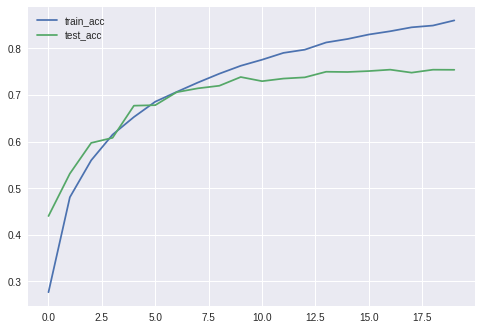

In [ ]:
# Plot training and test accuracy
plt.style.use('seaborn')
plt.plot(hist_KDL.history['accuracy'], label='train_acc', color='C0')
plt.plot(hist_KDL.history['val_accuracy'], label='test_acc', color='C1')
plt.legend()

In [ ]:
# Build the dense model using the functional API
# input layer
i = Input(shape=x_train[0].shape)

# Convolution Layer
x = Conv2D(16, (3, 3), activation='relu', padding='same')(i)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Dropout Layer
x = Dropout(0.2)(x)
x = Flatten()(x)
 
# Dense layers
x = Dense(4096, activation='relu')(x)

x = Dense(4096, activation='relu')(x)
 
# For output
x = Dense(10, activation='softmax')(x)

# Build model
model = Model(i, x)
 
# model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 64)        9280      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 8, 8, 256)         1477

In [ ]:
# Compile with learning rate 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
hist_dense = model.fit(
  x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
391/391 [==============================] - 577s 1s/step - loss: 1.5419 - accuracy: 0.4365 - val_loss: 1.2514 - val_accuracy: 0.5393
Epoch 2/20
391/391 [==============================] - 588s 2s/step - loss: 1.0730 - accuracy: 0.6198 - val_loss: 1.0179 - val_accuracy: 0.6424
Epoch 3/20
391/391 [==============================] - 578s 1s/step - loss: 0.8943 - accuracy: 0.6851 - val_loss: 0.8990 - val_accuracy: 0.6907
Epoch 4/20
391/391 [==============================] - 572s 1s/step - loss: 0.7637 - accuracy: 0.7304 - val_loss: 0.8032 - val_accuracy: 0.7264
Epoch 5/20
391/391 [==============================] - 603s 2s/step - loss: 0.6406 - accuracy: 0.7732 - val_loss: 0.7646 - val_accuracy: 0.7398
Epoch 6/20
391/391 [==============================] - 609s 2s/step - loss: 0.5382 - accuracy: 0.8095 - val_loss: 0.7873 - val_accuracy: 0.7375
Epoch 7/20
391/391 [==============================] - 612s 2s/step - loss: 0.4357 - accuracy: 0.8466 - val_loss: 0.7645 - val_accuracy: 0.7526

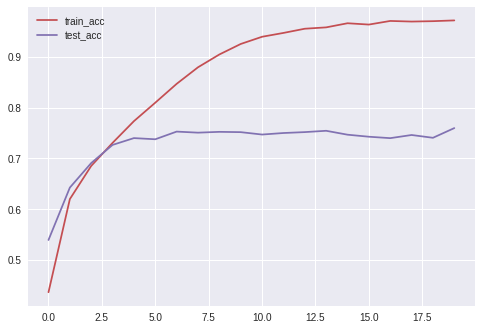

In [ ]:
# Plot training and test accuracy
plt.plot(hist_dense.history['accuracy'], label='train_acc', color='C2')
plt.plot(hist_dense.history['val_accuracy'], label='test_acc', color='C3')
plt.legend()

In [ ]:
# Build a KDL model with Kronecker rank of 4
# input layer
i = Input(shape=x_train[0].shape)

# Convolution Layer
x = Conv2D(16, (3, 3), activation='relu', padding='same')(i)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Dropout Layer
x = Dropout(0.2)(x)
x = Reshape((64,64))(x)
 
# KDL's (Kronecker rank 4)
x1 = KDLeftLayer(64, activation='relu')(x)
x1 = KDRightLayer(64)(x1)

x2 = KDRightLayer(64, activation='relu',init_factor=1e-15)(x)
x2 = KDLeftLayer(64,init_factor=1e-15)(x2)

x3 = KDLeftLayer(64, activation='relu',init_factor=1e-15)(x) 
x3 = KDRightLayer(64,init_factor=1e-15)(x3)

x4 = KDLeftLayer(64, activation='relu',init_factor=1e-15)(x)
x4 = KDRightLayer(64,init_factor=1e-15)(x4)
 
x = Add()([x1,x2,x3,x4]) # Combine layers before activation
x = ReLU()(x)

x1 = KDLeftLayer(64, activation='relu')(x)
x1 = KDRightLayer(64)(x1)

x2 = KDRightLayer(64, activation='relu',init_factor=1e-15)(x)
x2 = KDLeftLayer(64,init_factor=1e-15)(x2)

x3 = KDLeftLayer(64, activation='relu',init_factor=1e-15)(x) 
x3 = KDRightLayer(64,init_factor=1e-15)(x3)

x4 = KDLeftLayer(64, activation='relu',init_factor=1e-15)(x)
x4 = KDRightLayer(64,init_factor=1e-15)(x4)
 
x = Add()([x1,x2,x3,x4]) 
x = ReLU()(x)

# Another set of KDL's for output (Also Kronecker rank 4)
x1 = KDLeftLayer(2, activation='relu')(x)
x1 = KDRightLayer(5)(x1)

x2 = KDRightLayer(5, activation='relu',init_factor=1e-15)(x)
x2 = KDLeftLayer(2,init_factor=1e-15)(x2)

x3 = KDLeftLayer(2, activation='relu',init_factor=1e-15)(x)
x3 = KDRightLayer(5,init_factor=1e-15)(x3)

x4 = KDLeftLayer(2, activation='relu',init_factor=1e-15)(x)
x4 = KDRightLayer(5,init_factor=1e-15)(x4)

x = Add()([x1,x2,x3,x4])
x = Flatten()(x)
x = Softmax()(x)
model = Model(i, x)
 
# model description
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_33 (Conv2D)             (None, 32, 32, 16)   448         ['input_12[0][0]']               
                                                                                                  
 max_pooling2d_33 (MaxPooling2D  (None, 16, 16, 16)  0           ['conv2d_33[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 16, 16, 64)   9280        ['max_pooling2d_33[0][0]'] 

In [ ]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist_KDL4 = model.fit(
  x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
391/391 [==============================] - 204s 514ms/step - loss: 1.9539 - accuracy: 0.2734 - val_loss: 1.5880 - val_accuracy: 0.4086
Epoch 2/20
391/391 [==============================] - 198s 506ms/step - loss: 1.4801 - accuracy: 0.4568 - val_loss: 1.3074 - val_accuracy: 0.5190
Epoch 3/20
391/391 [==============================] - 198s 507ms/step - loss: 1.2813 - accuracy: 0.5362 - val_loss: 1.2207 - val_accuracy: 0.5546
Epoch 4/20
391/391 [==============================] - 200s 510ms/step - loss: 1.1421 - accuracy: 0.5894 - val_loss: 1.0593 - val_accuracy: 0.6187
Epoch 5/20
391/391 [==============================] - 199s 510ms/step - loss: 1.0449 - accuracy: 0.6258 - val_loss: 0.9873 - val_accuracy: 0.6473
Epoch 6/20
391/391 [==============================] - 202s 516ms/step - loss: 0.9548 - accuracy: 0.6599 - val_loss: 0.9817 - val_accuracy: 0.6503
Epoch 7/20
391/391 [==============================] - 201s 514ms/step - loss: 0.8957 - accuracy: 0.6828 - val_loss: 0.9178 -

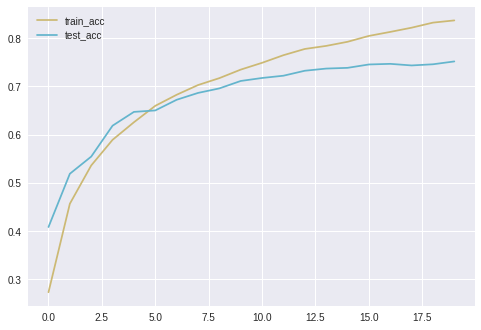

In [ ]:
# Plot training and test accuracy
plt.plot(hist_KDL4.history['accuracy'], label='train_acc', color='C4')
plt.plot(hist_KDL4.history['val_accuracy'], label='test_acc', color='C5')
plt.legend()

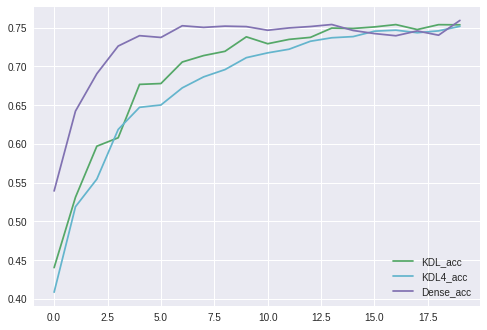

In [ ]:
# Plot test accuracy comparison
plt.plot(hist_KDL.history['val_accuracy'], label='KDL_acc', color='C1')
plt.plot(hist_KDL4.history['val_accuracy'], label='KDL4_acc', color='C5')
plt.plot(hist_dense.history['val_accuracy'], label='Dense_acc', color='C3')
plt.legend()